# Calculates expected number of laten qubits using Schumacher eigenstates

Sources:
* https://web.mit.edu/6.962/www/www_spring_2001/yonina/schumacher.pdf

In [1]:
# Cell 1 — imports & helpers
import json
import numpy as np
import math
from scipy.linalg import eigh
import matplotlib.pyplot as plt

# Load data helper func
def json_entry_to_state(entry):
    arr = np.array(entry["statevector"], dtype=float)  # shape (N,2)
    psi = arr[:,0] + 1j*arr[:,1]
    norm = np.linalg.norm(psi)

    return psi / norm


In [2]:
# Load dataset and build matrix of states
PATH = "beh2_states_dataset.json"   # change if needed

with open(PATH, "r") as f:
    data = json.load(f)

M = len(data)
print("Number of states (M):", M)

# Convert to complex vectors and stack into matrix Phi with shape (N, M)
states = [json_entry_to_state(entry) for entry in data]
N = states[0].size
Phi = np.column_stack(states)   # shape (N, M)

print("Hilbert-space dimension (N):", N)
print("Phi shape (N, M):", Phi.shape)


Number of states (M): 625
Hilbert-space dimension (N): 16384
Phi shape (N, M): (16384, 625)


In [3]:
# Cell 3 — build rho (full matrix)
M = Phi.shape[1]
rho = (Phi @ Phi.conj().T) / M    # shape (N, N)
print("rho shape:", rho.shape)
print("rho trace (should be ~1):", np.trace(rho).real)


rho shape: (16384, 16384)
rho trace (should be ~1): 1.0


In [4]:
# Cell 4 — eigen-decompose rho
# Use eigh which assumes Hermitian; it returns ascending eigenvalues, so reverse them.
eigvals, eigvecs = eigh(rho)   # eigvals ascending
eigvals = eigvals[::-1].real
eigvecs = eigvecs[:, ::-1]     # columns are eigenvectors corresponding to eigvals

# quick sanity
print("Top eigenvalues (first 10):", eigvals[:10])
print("Sum of eigenvalues (trace):", eigvals.sum())


Top eigenvalues (first 10): [9.04022156e-01 2.81586567e-02 2.29516687e-02 1.77495453e-02
 1.49779556e-02 6.46363941e-03 1.94234041e-03 1.19662814e-03
 8.07472029e-04 3.87139972e-04]
Sum of eigenvalues (trace): 0.9999999999999977


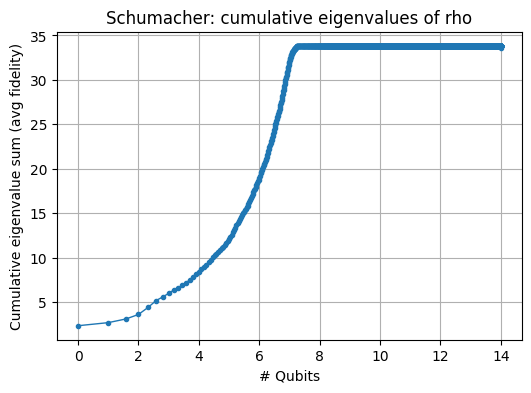

Target avg fid 0.900: d_needed = 1, minimal latent qubits m = 0 (2^m = 1)
Target avg fid 0.950: d_needed = 3, minimal latent qubits m = 2 (2^m = 4)
Target avg fid 0.990: d_needed = 6, minimal latent qubits m = 3 (2^m = 8)
Target avg fid 0.999: d_needed = 11, minimal latent qubits m = 4 (2^m = 16)


In [15]:
# Cell 5 — cumulative plot and table of qubit mapping
cum = np.cumsum(eigvals)    # cum[k-1] = sum of top k eigenvalues

# Plot
plt.figure(figsize=(6,4))
plt.plot(np.log2(np.arange(1, len(cum)+1)), -np.log(1-cum), marker='o', markersize=3, linewidth=1)
plt.xlabel("# Qubits")
plt.ylabel("Cumulative eigenvalue sum (avg fidelity)")
plt.grid(True)
plt.title("Schumacher: cumulative eigenvalues of rho")
plt.show()

# Print useful thresholds: minimal d for target fidelities
targets = [0.90, 0.95, 0.99, 0.999]
for t in targets:
    d_needed = np.searchsorted(cum, t) + 1
    m_qubits = math.ceil(math.log2(d_needed))
    print(f"Target avg fid {t:.3f}: d_needed = {d_needed}, minimal latent qubits m = {m_qubits} (2^m = {2**m_qubits})")

In [9]:
import csv

with open("density_matrix_eigvals.csv", "w", newline="") as f:
    writer = csv.writer(f)
    for item in eigvals:
        writer.writerow([item])